## AI & Machine Learning for Data Quality
**Description**: AI and machine learning can automate and enhance data quality checks by learning patterns and identifying anomalies more effectively than static rules.

**Task 1**: Training a model to predict and flag unusual trend patterns in sales data that
deviate from historical norms.

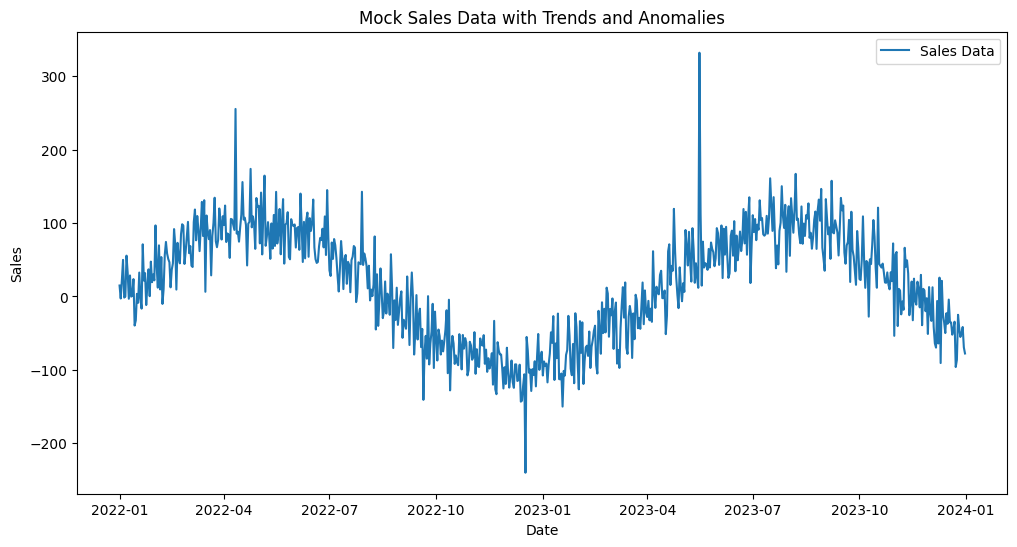

NameError: name 'IsolationForest' is not defined

In [1]:
# write your code from here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Generate mock sales data over 2 years (730 days)
dates = pd.date_range(start="2022-01-01", periods=730, freq="D")
sales = np.sin(np.linspace(0, 10, 730)) * 100 + np.random.normal(0, 30, 730)  # Sine wave trend + noise

# Introduce some anomalies (outliers)
sales[100] += 200
sales[350] -= 150
sales[500] += 250

# Create a DataFrame
df_sales = pd.DataFrame({"date": dates, "sales": sales})

# Visualize the sales data
plt.figure(figsize=(12, 6))
plt.plot(df_sales['date'], df_sales['sales'], label="Sales Data")
plt.title("Mock Sales Data with Trends and Anomalies")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

df_sales.head()
# Add rolling mean and rolling standard deviation
# Ensure that we drop NaN values only from the features DataFrame, and keep the index aligned
df_sales['rolling_mean'] = df_sales['sales'].rolling(window=7).mean()  # 7-day moving average
df_sales['rolling_std'] = df_sales['sales'].rolling(window=7).std()  # 7-day moving standard deviation

# Add additional time-based features
df_sales['day_of_week'] = df_sales['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df_sales['month'] = df_sales['date'].dt.month

# Drop rows where the rolling mean or rolling std has NaN values (the first 6 rows)
features = df_sales[['rolling_mean', 'rolling_std', 'day_of_week', 'month']].dropna()

# Initialize and train the Isolation Forest model
model = IsolationForest(contamination=0.05)  # 5% contamination (anomalies)
model.fit(features)

# Predict anomalies: -1 for anomaly, 1 for normal
anomaly_predictions = model.predict(features)

# Map the anomaly predictions back to the original dataframe
df_sales.loc[features.index, 'anomaly'] = anomaly_predictions

# Convert anomaly column to 0 and 1 for better interpretation (0 = normal, 1 = anomaly)
df_sales['anomaly'] = df_sales['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Visualize the anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_sales['date'], df_sales['sales'], label="Sales Data")
plt.scatter(df_sales[df_sales['anomaly'] == 1]['date'], 
            df_sales[df_sales['anomaly'] == 1]['sales'], 
            color='red', label="Anomalies", zorder=5)
plt.title("Sales Data with Anomalies Detected")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()



**Task 2**: Using clustering algorithms to detect duplicate records where entries are not
exactly identical.

In [ ]:
# write your code from here
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.sparse import hstack

# Step 1: Create a mock dataset
data = {
    'name': ['John Doe', 'John Dae', 'Jon Doe', 'Jane Smith', 'Jane Smithe', 'Jana Smith', 'Johnathan Doe'],
    'address': ['123 Main St', '123 Main Street', '124 Main St', '456 Oak Ave', '456 Oak Avenue', '457 Oak Ave', '123 Main St'],
    'phone': ['555-1234', '555-1234', '555-1234', '555-5678', '555-5679', '555-5678', '555-1234']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Step 2: Preprocess the data using TF-IDF vectorization for the 'name' and 'address' columns
vectorizer_name = TfidfVectorizer(stop_words='english')
vectorizer_address = TfidfVectorizer(stop_words='english')

# Fit and transform the data
name_vectors = vectorizer_name.fit_transform(df['name'])
address_vectors = vectorizer_address.fit_transform(df['address'])

# Combine the vectors into one feature set
features = hstack([name_vectors, address_vectors])

# Step 3: Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')  # Using cosine similarity for text data
df['cluster'] = dbscan.fit_predict(features)

# Step 4: Detect duplicates by identifying records in the same cluster
# DBSCAN assigns -1 to noise points, so we exclude those
duplicates = df[df['cluster'] != -1]  # Potential duplicates are in the same cluster

# Step 5: Display the potential duplicates
print("Potential duplicates (same cluster):")
print(duplicates)

# Step 6: Optional - Visualize the clusters
plt.scatter(df.index, df['cluster'], c=df['cluster'], cmap='viridis')
plt.title("DBSCAN Clusters")
plt.xlabel("Record Index")
plt.ylabel("Cluster ID")
plt.show()


**Task 3**: Implementing classification models to validate data based on learned
characteristics from labeled datasets.

In [ ]:
# write your code from here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Step 1: Create a mock labeled dataset (features and labels)
data = {
    'age': [23, 35, 45, 50, 29, 40, 33, 60, 21, 38],
    'income': [40000, 50000, 60000, 70000, 35000, 80000, 65000, 120000, 32000, 70000],
    'years_of_experience': [1, 10, 15, 20, 2, 12, 9, 30, 0, 13],
    'is_valid': [1, 1, 1, 1, 0, 1, 1, 1, 0, 1]  # 1 = valid, 0 = invalid
}

df = pd.DataFrame(data)

# Step 2: Preprocessing
# Separate features and label
X = df.drop(columns=['is_valid'])
y = df['is_valid']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (scaling the data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train a classification model (Random Forest Classifier)
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Step 4: Evaluate the model's performance
y_pred = model.predict(X_test_scaled)

# Evaluate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Cross-validation for model evaluation
cv_scores = cross_val_score(model, X_scaled, y, cv=5)  # 5-fold cross-validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")

# Step 5: Validate new data (predict if valid or invalid based on the learned model)
new_data = pd.DataFrame({
    'age': [30],
    'income': [55000],
    'years_of_experience': [5]
})

# Preprocess and predict the validity of new data
new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)

print(f"Prediction for new data (valid/invalid): {prediction[0]}")

